<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/3D_LBM_for_FluidDynamicsSimualtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lattice Boltzmann Method (LBM) Overview

The Lattice Boltzmann Method (LBM) is a numerical simulation technique used to model fluid dynamics, particularly in complex geometries and multi-phase flows. Unlike traditional computational fluid dynamics (CFD) methods that solve the Navier-Stokes equations directly, LBM simulates the microscopic kinetic processes of fluid particles on a discrete lattice grid. The method is based on the Boltzmann equation, which describes the statistical behavior of a thermodynamic system.

## LBM Basics

In LBM, the fluid is represented by a distribution function \( f_i(\mathbf{x}, t) \) at each lattice node \( \mathbf{x} \) and discrete time \( t \). The distribution function describes the probability of finding a particle with a certain velocity \( \mathbf{e}_i \) at a particular point and time. The evolution of this function over time is governed by the Lattice Boltzmann equation:


\begin{align}
f_i(\mathbf{x} + \mathbf{e}_i \Delta t, t + \Delta t) - f_i(\mathbf{x}, t) = -\frac{f_i(\mathbf{x}, t) - f_i^{\text{eq}}(\mathbf{x}, t)}{\tau}
\end{align}


where:
- e_i are the discrete lattice velocities,
- Delta t  is the time step,
- tau  is the relaxation time,
- f_i is the equilibrium distribution function.

The macroscopic properties of the fluid, such as density \( \rho \) and velocity \( \mathbf{u} \), are obtained by taking moments of the distribution function:


\begin{align}
\rho(\mathbf{x}, t) = \sum_i f_i(\mathbf{x}, t)
\end{align}



\begin{align}
\rho(\mathbf{x}, t) \mathbf{u}(\mathbf{x}, t) = \sum_i f_i(\mathbf{x}, t) \mathbf{e}_i
\end{align}
  

## Notes on Delta t  
Typically, in LBM simulations, deltaT is often assumed to be 1 because LBM operates on a lattice where both time and space are discretized in units of the lattice. This simplification is part of what makes LBM numerically efficient.  So using it explicit is typically not necessary unless you are coupling LBM with other methods or working with non-standard time-stepping schemes. The current codes works under the assumption that deltaT = 1.  

## Discrete Velocity Models

The choice of lattice grid and velocity vectors e_i determines the specific LBM model. Different models are used depending on the dimensionality and complexity of the simulation.  
Below D2Q9 and D3Q27:

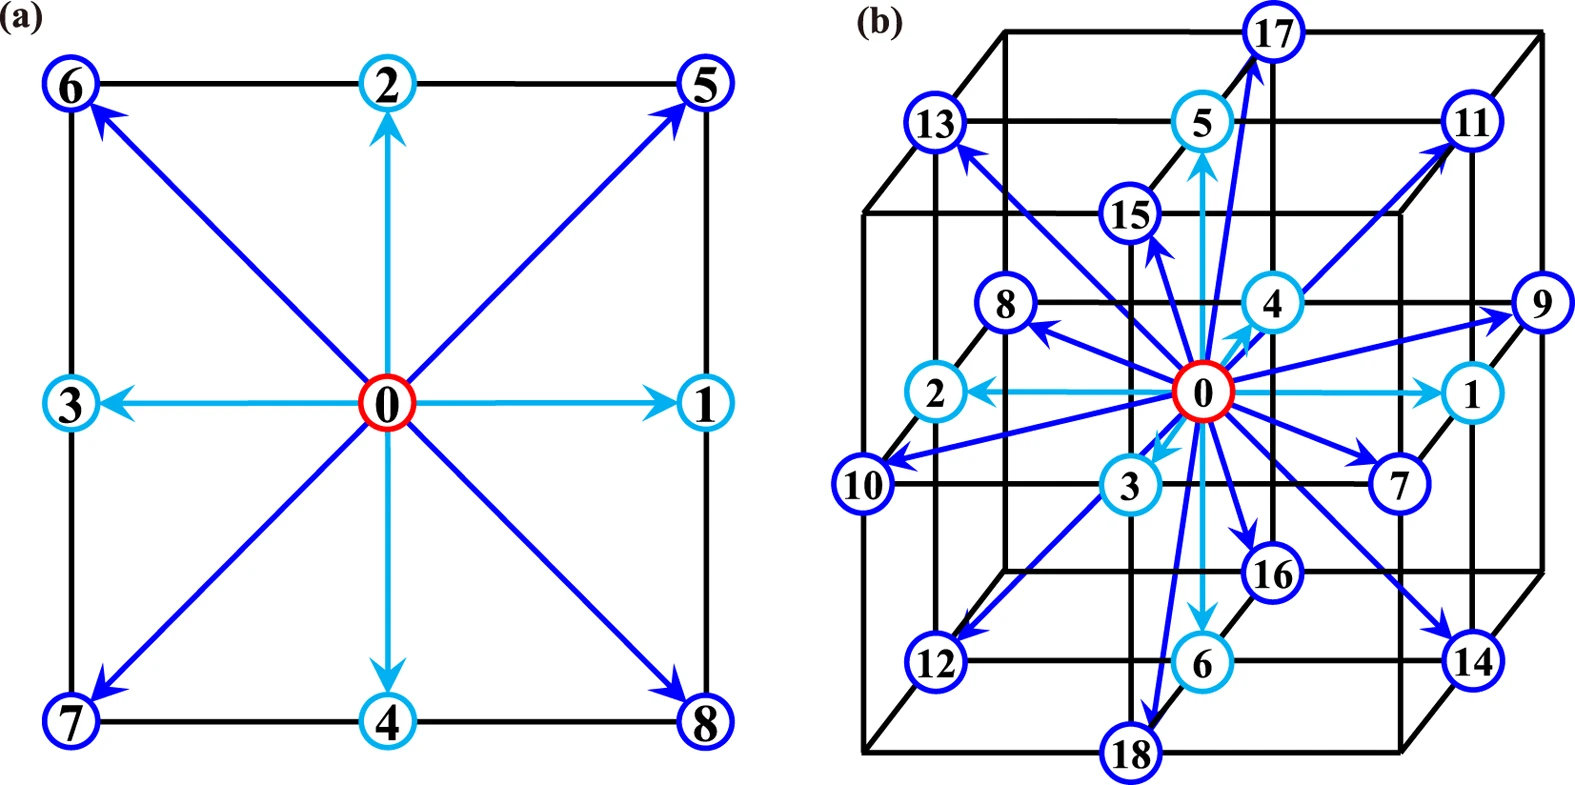  [1].  


## Summary

LBM is a versatile and powerful tool for simulating fluid flows, particularly in complex geometries and multi-phase systems. The choice of model (D2Q5, D2Q9, D3Q15, D3Q27) depends on the required dimensionality, accuracy, and computational resources. D2Q9 is widely used in 2D simulations for its balance between simplicity and accuracy, while D3Q27 provides the highest accuracy for 3D simulations at the cost of increased computational demand.


In [ ]:
# @title Imports

import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from   IPython.display import Image
import os


### 1. **D2Q5 Model**
- **Dimensionality:** 2D
- **Number of Velocities (Q):** 5
- **Velocity Vectors:**
  - e_0 = (0, 0)  (rest)
  - e_1 = (1, 0) , e_2 = (0, 1), e_3 = (-1, 0), e_4 = (0, -1) (directions along the axes)

- **Applications:** Simplified 2D simulations with basic flow characteristics.


In [ ]:
# @title D2Q5 LBM

# Simulation parameters
nx, ny = 200, 50       # Grid size
tau = 0.6              # Relaxation time
nu = (tau - 0.5) / 3.0 # Kinematic viscosity
rho0 = 1.0             # Initial density
u_in = 0.15             # Inlet velocity
timesteps = 1000       # Number of simulation steps
save_interval = 50     # Save every 50 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80, 'y': 20, 'size': 10},  # Block at (80, 20) with size 10x10
    {'x': 120, 'y': 30, 'size': 5}   # Block at (120, 30) with size 5x5
]

# LBM parameters for D2Q5
weights = np.array([1/3, 1/6, 1/6, 1/6, 1/6])
c = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1]])
opposite = [0, 3, 4, 1, 2]

# Initialize macroscopic variables
u_array = np.zeros((nx, ny, 2))  # Velocity components u_x, u_y
rho_array = np.full((nx, ny), rho0)
f_array = np.zeros((nx, ny, 5))  # Distribution functions

# Initialize the distribution functions
for i in range(5):
    cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
    f_array[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, size = block['x'], block['y'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, [1, 2, 3, 4]] = f_array[x:x+size, y:y+size, [3, 4, 1, 2]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, 0] = u_in
    u_array[0, :, 1] = 0
    rho_in = f_array[0, :, :].sum(axis=1) / (1 - u_in)
    f_array[0, :, 1] = f_array[0, :, 3] + 2 * rho_in * u_in / 3

    # No-slip at top and bottom walls
    f_array[:, 0, [2]] = f_array[:, 0, [4]]
    f_array[:, -1, [4]] = f_array[:, -1, [2]]

    # Outlet - free outflow
    f_array[-1, :, :] = f_array[-2, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(5):
        cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
        feq[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(5):
        f_array[:,:,i] = np.roll(f_array[:,:,i], c[i], axis=(0, 1))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=2)
    u_array[:,:,0] = (f_array * c[:,0]).sum(axis=2) / rho_array
    u_array[:,:,1] = (f_array * c[:,1]).sum(axis=2) / rho_array

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d2q5.npz', history=history)


### 2. **D2Q9 Model**
- **Dimensionality:** 2D
- **Number of Velocities (Q):** 9
- **Velocity Vectors:**
  - e_0 = (0, 0) (rest)
  - e_1 = (1, 0), e_2 = (0, 1), e_3 = (-1, 0), e_4 = (0, -1) (axes)
  - e_5 = (1, 1), e_6 = (-1, 1), e_7 = (-1, -1), e_8 = (1, -1) (diagonals)

- **Applications:** Most common 2D model, used for simulating a wide range of fluid dynamics problems such as flows around obstacles, lid-driven cavity flow, and other scenarios requiring more accuracy.

In [ ]:
# @title D2Q9 LBM

# Simulation parameters
nx, ny = 200, 50       # Grid size
tau = 0.6              # Relaxation time
nu = (tau - 0.5) / 3.0 # Kinematic viscosity
rho0 = 1.0             # Initial density
u_in = 0.10             # Inlet velocity
timesteps = 1500      # Number of simulation steps
save_interval = 50     # Save every 50 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80,  'y': 20, 'size': 10},  # Block at (80, 20) with size 10x10
    {'x': 120, 'y': 30, 'size': 5}   # Block at (120, 30) with size 5x5
]

# LBM parameters
weights = np.array([4/9] + [1/9]*4 + [1/36]*4)
c = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1], [1,1], [-1,1], [-1,-1], [1,-1]])
opposite = [0, 3, 4, 1, 2, 7, 8, 5, 6]

# Initialize macroscopic variables
u_array = np.zeros((nx, ny, 2))  # Velocity components u_x, u_y
rho_array = np.full((nx, ny), rho0)
f_array = np.zeros((nx, ny, 9))  # Distribution functions

# Initialize the distribution functions
for i in range(9):
    cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
    f_array[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, size = block['x'], block['y'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, [1, 2, 3, 4, 5, 6, 7, 8]] = f_array[x:x+size, y:y+size, [3, 4, 1, 2, 7, 8, 5, 6]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, 0] = u_in
    u_array[0, :, 1] = 0
    rho_in = f_array[0, :, :].sum(axis=1) / (1 - u_in)
    f_array[0, :, 1] = f_array[0, :, 3] + 2 * rho_in * u_in / 3
    f_array[0, :, 5] = f_array[0, :, 7] + rho_in * u_in / 6
    f_array[0, :, 8] = f_array[0, :, 6] + rho_in * u_in / 6

    # No-slip at top and bottom walls
    f_array[:, 0,  [2, 5, 6]] = f_array[:, 0, [4, 7, 8]]
    f_array[:, -1, [4, 7, 8]] = f_array[:, -1, [2, 5, 6]]

    # Outlet - free outflow
    f_array[-1, :, :] = f_array[-2, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(9):
        cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
        feq[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(9):
        f_array[:,:,i] = np.roll(f_array[:,:,i], c[i], axis=(0, 1))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=2)
    u_array[:,:,0] = (f_array * c[:,0]).sum(axis=2) / rho_array
    u_array[:,:,1] = (f_array * c[:,1]).sum(axis=2) / rho_array

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d2q9.npz', history=history)


In [ ]:
# @title D2Q9 PETSc (set-upping petsc in Colab is time consuming, consider running it in local env)

!pip install petsc4py
import petsc4py
petsc4py.init()
from petsc4py import PETSc


# Simulation parameters
nx, ny = 200, 50       # Grid size
tau = 0.6              # Relaxation time
nu = (tau - 0.5) / 3.0 # Kinematic viscosity
rho0 = 1.0             # Initial density
u_in = 0.1             # Inlet velocity
timesteps = 10000      # Number of simulation steps
save_interval = 50     # Save every 5 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80, 'y': 20, 'size': 10},  # Block at (80, 20) with size 10x10
    {'x': 120, 'y': 30, 'size': 5}   # Block at (120, 30) with size 5x5
]

# LBM parameters
weights = np.array([4/9] + [1/9]*4 + [1/36]*4)
c = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1], [1,1], [-1,1], [-1,-1], [1,-1]])
opposite = [0, 3, 4, 1, 2, 7, 8, 5, 6]

# Initialize macroscopic variables using PETSc vectors
u = PETSc.Vec().createMPI((nx * ny * 2, None))  # For velocity components u_x, u_y
rho = PETSc.Vec().createMPI((nx * ny, None))    # For density
f = PETSc.Vec().createMPI((nx * ny * 9, None))  # For distribution functions

# Local arrays for easier manipulation
u_array = np.zeros((nx, ny, 2))
rho_array = np.full((nx, ny), rho0)
f_array = np.zeros((nx, ny, 9))

# Initialize the distribution functions
for i in range(9):
    cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
    f_array[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))

# Scatter to PETSc vectors
u.setArray(u_array.flatten())
rho.setArray(rho_array.flatten())
f.setArray(f_array.flatten())

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, size = block['x'], block['y'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, [1, 2, 3, 4, 5, 6, 7, 8]] = f_array[x:x+size, y:y+size, [3, 4, 1, 2, 7, 8, 5, 6]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, 0] = u_in
    u_array[0, :, 1] = 0
    rho_in = f_array[0, :, :].sum(axis=1) / (1 - u_in)
    f_array[0, :, 1] = f_array[0, :, 3] + 2 * rho_in * u_in / 3
    f_array[0, :, 5] = f_array[0, :, 7] + rho_in * u_in / 6
    f_array[0, :, 8] = f_array[0, :, 6] + rho_in * u_in / 6

    # No-slip at top and bottom walls
    f_array[:, 0, [2, 5, 6]] = f_array[:, 0, [4, 7, 8]]
    f_array[:, -1, [4, 7, 8]] = f_array[:, -1, [2, 5, 6]]

    # Outlet - free outflow
    f_array[-1, :, :] = f_array[-2, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Fetch data from PETSc vectors into numpy arrays
    u_array = np.array(u.getArray()).reshape(nx, ny, 2)
    rho_array = np.array(rho.getArray()).reshape(nx, ny)
    f_array = np.array(f.getArray()).reshape(nx, ny, 9)

    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(9):
        cu = 3 * (c[i,0] * u_array[:,:,0] + c[i,1] * u_array[:,:,1])
        feq[:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,0]**2 + u_array[:,:,1]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(9):
        f_array[:,:,i] = np.roll(f_array[:,:,i], c[i], axis=(0, 1))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=2)
    u_array[:,:,0] = (f_array * c[:,0]).sum(axis=2) / rho_array
    u_array[:,:,1] = (f_array * c[:,1]).sum(axis=2) / rho_array

    # Update PETSc vectors
    u.setArray(u_array.flatten())
    rho.setArray(rho_array.flatten())
    f.setArray(f_array.flatten())

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d2q9_petsc.npz', history=history)


### Results Post Processing & Visualization (2D)

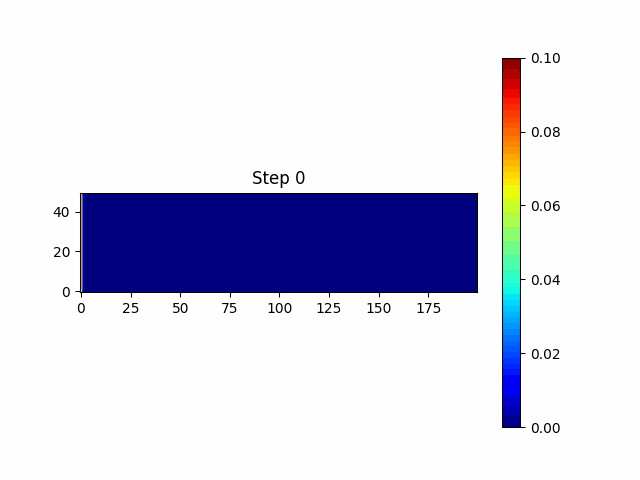

In [ ]:
# @title 2D Post Processing

FILENAME = 'lbm_sim_d2q9'

# Load simulation history
data = np.load(FILENAME+'.npz')
history = data['history']

# Directory to save frames
frames_dir = 'frames_'+FILENAME
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Create a GIF from the simulation history
frames = []
for i in range(len(history)):
    u_x = history[i][:,:,0]  # X-component of the velocity
    plt.imshow(u_x.T, origin='lower', cmap='jet', interpolation='bilinear')
    plt.colorbar()
    plt.title(f'Step {i * 5}')

    # Save the current frame to a file in the frames directory
    frame_path = os.path.join(frames_dir, f'frame_{i}.png')
    plt.savefig(frame_path)
    plt.close()

    # Read the saved frame
    frames.append(imageio.imread(frame_path))

# Save the frames as a GIF
imageio.mimsave(FILENAME+'.gif', frames, fps=10, loop=0)

# Optional: Clean up frame files if no longer needed
#import shutil
#shutil.rmtree(frames_dir)
Image(filename=FILENAME+'.gif')




---



### 3. **D3Q15 Model**
- **Dimensionality:** 3D
- **Number of Velocities (Q):** 15
- **Velocity Vectors:**
  - e_0 = (0, 0, 0) (rest)
  - e_1 = (1, 0, 0), e_2 = (0, 1, 0), e_3 = (0, 0, 1) (axes)
  - e_4 = (1, 1, 0), e_5 = (1, 0, 1), e_6 = (0, 1, 1) (face-centered)

- **Applications:** 3D flows requiring moderate accuracy, simpler simulations in three dimensions, and scenarios where computational efficiency is a concern.

In [ ]:
# @title D3Q15 LBM

# Simulation parameters
nx, ny, nz = 200, 50, 50  # Grid size in 3D
tau = 0.6                 # Relaxation time
nu = (tau - 0.5) / 3.0    # Kinematic viscosity
rho0 = 1.0                # Initial density
u_in = 0.1                # Inlet velocity
timesteps = 1500           # Number of simulation steps
save_interval = 50        # Save every 50 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80,  'y': 20, 'z': 20, 'size': 10},  # Block at (80, 20, 20) with size 10x10x10
    {'x': 120, 'y': 30, 'z': 30, 'size': 5}
]


# LBM parameters for D3Q15
weights = np.array([2/9] + [1/9]*6 + [1/72]*8)
c = np.array([[0,0,0], [1,0,0], [0,1,0], [0,0,1], [-1,0,0], [0,-1,0], [0,0,-1],
              [1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,-1], [-1,1,-1], [-1,-1,-1], [1,-1,-1]])
opposite = [0, 4, 5, 6, 1, 2, 3, 14, 13, 12, 11, 10, 9, 8, 7]

# Initialize macroscopic variables
u_array = np.zeros((nx, ny, nz, 3))  # Velocity components u_x, u_y, u_z
rho_array = np.full((nx, ny, nz), rho0)
f_array = np.zeros((nx, ny, nz, 15))  # Distribution functions

# Initialize the distribution functions
for i in range(15):
    cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
    f_array[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, z, size = block['x'], block['y'], block['z'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, z:z+size, 1:15] = f_array[x:x+size, y:y+size, z:z+size, opposite[1:15]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, :, 0] = u_in
    u_array[0, :, :, 1] = 0
    u_array[0, :, :, 2] = 0
    rho_in = f_array[0, :, :, :].sum(axis=2) / (1 - u_in)
    f_array[0, :, :, 1] = f_array[0, :, :, 4] + 2 * rho_in * u_in / 3

    # No-slip at top and bottom walls (y)
    f_array[:, 0, :, [2, 7, 11, 12]] = f_array[:, 0, :, [5, 8, 14, 13]]
    f_array[:, -1, :, [5, 8, 14, 13]] = f_array[:, -1, :, [2, 7, 11, 12]]

    # No-slip at front and back walls (z)
    f_array[:, :, 0, [3, 7, 8, 10]] = f_array[:, :, 0, [6, 14, 13, 11]]
    f_array[:, :, -1, [6, 14, 13, 11]] = f_array[:, :, -1, [3, 7, 8, 10]]

    # Outlet - free outflow
    f_array[-1, :, :, :] = f_array[-2, :, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(15):
        cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
        feq[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(15):
        f_array[:,:,:,i] = np.roll(f_array[:,:,:,i], c[i], axis=(0, 1, 2))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=3)
    u_array[:,:,:,0] = (f_array * c[:,0]).sum(axis=3) / rho_array
    u_array[:,:,:,1] = (f_array * c[:,1]).sum(axis=3) / rho_array
    u_array[:,:,:,2] = (f_array * c[:,2]).sum(axis=3) / rho_array

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d3q15.npz', history=history)


### 4. **D3Q27 Model**
- **Dimensionality:** 3D
- **Number of Velocities (Q):** 27
- **Velocity Vectors:**
  - e_0 = (0, 0, 0) (rest)
  - e_1 = (1, 0, 0), e_2 = (0, 1, 0), e_3 = (0, 0, 1) (axes)
  - e_4 = (1, 1, 0), e_5 = (1, 0, 1), e_6 = (0, 1, 1) (face-centered)
  - e_7 = (1, 1, 1) (corner-centered)

- **Applications:** High-accuracy 3D simulations, complex geometries, and scenarios requiring detailed flow characteristics.

In [ ]:
# @title D3Q27 LBM

# Simulation parameters
nx, ny, nz = 200, 50, 50  # Grid size in 3D
tau = 0.6                 # Relaxation time
nu = (tau - 0.5) / 3.0    # Kinematic viscosity
rho0 = 1.0                # Initial density
u_in = 0.1                # Inlet velocity
timesteps = 1500         # Number of simulation steps
save_interval = 50        # Save every 50 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80,  'y': 20, 'z': 20, 'size': 10},  # Block at (80, 20, 20) with size 10x10x10
    {'x': 120, 'y': 30, 'z': 30, 'size': 5}
]

# LBM parameters for D3Q27
weights = np.array([8/27] + [2/27]*6 + [1/54]*12 + [1/216]*8)
c = np.array([[0,0,0],
              [1,0,0], [0,1,0], [0,0,1], [-1,0,0], [0,-1,0], [0,0,-1], # Face-centered
              [1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0], [1,0,1], [1,0,-1], [-1,0,1], [-1,0,-1], [0,1,1], [0,1,-1], [0,-1,1], [0,-1,-1], # Edge-centered
              [1,1,1], [1,1,-1], [1,-1,1], [1,-1,-1], [-1,1,1], [-1,1,-1], [-1,-1,1], [-1,-1,-1]]) # Corner-centered
opposite = [0, 4, 5, 6, 1, 2, 3,
            10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 16, 17,
            26, 25, 24, 23, 22, 21, 20, 19]

# Initialize macroscopic variables
u_array = np.zeros((nx, ny, nz, 3))  # Velocity components u_x, u_y, u_z
rho_array = np.full((nx, ny, nz), rho0)
f_array = np.zeros((nx, ny, nz, 27))  # Distribution functions

# Initialize the distribution functions
for i in range(27):
    cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
    f_array[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, z, size = block['x'], block['y'], block['z'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, z:z+size, 1:27] = f_array[x:x+size, y:y+size, z:z+size, opposite[1:27]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, :, 0] = u_in
    u_array[0, :, :, 1] = 0
    u_array[0, :, :, 2] = 0
    rho_in = f_array[0, :, :, :].sum(axis=2) / (1 - u_in)
    f_array[0, :, :, 1] = f_array[0, :, :, 4] + 2 * rho_in * u_in / 3

    # No-slip at top and bottom walls (y)
    f_array[:, 0, :, [2, 7, 10, 14, 18]] = f_array[:, 0, :, [5, 11, 9, 15, 19]]
    f_array[:, -1, :, [5, 11, 9, 15, 19]] = f_array[:, -1, :, [2, 7, 10, 14, 18]]

    # No-slip at front and back walls (z)
    f_array[:, :, 0, [3, 7, 8, 12, 16]] = f_array[:, :, 0, [6, 13, 15, 14, 18]]
    f_array[:, :, -1, [6, 13, 15, 14, 18]] = f_array[:, :, -1, [3, 7, 8, 12, 16]]

    # Outlet - free outflow
    f_array[-1, :, :, :] = f_array[-2, :, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(27):
        cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
        feq[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(27):
        f_array[:,:,:,i] = np.roll(f_array[:,:,:,i], shift=c[i], axis=(0, 1, 2))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=3)
    u_array[:,:,:,0] = (f_array * c[:,0]).sum(axis=3) / rho_array
    u_array[:,:,:,1] = (f_array * c[:,1]).sum(axis=3) / rho_array
    u_array[:,:,:,2] = (f_array * c[:,2]).sum(axis=3) / rho_array

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d3q27.npz', history=history)


In [ ]:
# @title D3Q27 PETSc (set-upping petsc in Colab is time consuming, consider running it in local env)

!pip install petsc4py
import petsc4py
petsc4py.init()
from petsc4py import PETSc
import numpy as np

# Simulation parameters
nx, ny, nz = 200, 50, 50  # Grid size in 3D
tau = 0.6                 # Relaxation time
nu = (tau - 0.5) / 3.0    # Kinematic viscosity
rho0 = 1.0                # Initial density
u_in = 0.1                # Inlet velocity
timesteps = 1500          # Number of simulation steps
save_interval = 50        # Save every 50 steps

# Block parameters (user can define these)
blocks = [
    {'x': 80,  'y': 20, 'z': 20, 'size': 10},  # Block at (80, 20, 20) with size 10x10x10
    {'x': 120, 'y': 30, 'z': 30, 'size': 5}
]

# LBM parameters for D3Q27
weights = np.array([8/27] + [2/27]*6 + [1/54]*12 + [1/216]*8)
c = np.array([[0,0,0],
              [1,0,0], [0,1,0], [0,0,1], [-1,0,0], [0,-1,0], [0,0,-1], # Face-centered
              [1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0], [1,0,1], [1,0,-1], [-1,0,1], [-1,0,-1], [0,1,1], [0,1,-1], [0,-1,1], [0,-1,-1], # Edge-centered
              [1,1,1], [1,1,-1], [1,-1,1], [1,-1,-1], [-1,1,1], [-1,1,-1], [-1,-1,1], [-1,-1,-1]]) # Corner-centered
opposite = [0, 4, 5, 6, 1, 2, 3,
            10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 16, 17,
            26, 25, 24, 23, 22, 21, 20, 19]

# Initialize macroscopic variables using PETSc vectors
u = PETSc.Vec().createMPI((nx * ny * nz * 3, None))  # For velocity components u_x, u_y, u_z
rho = PETSc.Vec().createMPI((nx * ny * nz, None))    # For density
f = PETSc.Vec().createMPI((nx * ny * nz * 27, None)) # For distribution functions

# Local arrays for easier manipulation
u_array = np.zeros((nx, ny, nz, 3))
rho_array = np.full((nx, ny, nz), rho0)
f_array = np.zeros((nx, ny, nz, 27))

# Initialize the distribution functions
for i in range(27):
    cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
    f_array[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))

# Scatter to PETSc vectors
u.setArray(u_array.flatten())
rho.setArray(rho_array.flatten())
f.setArray(f_array.flatten())

# Storage for simulation history
history = []

# Function to apply no-slip conditions for blocks
def apply_no_slip_blocks(f_array, blocks):
    for block in blocks:
        x, y, z, size = block['x'], block['y'], block['z'], block['size']
        # Apply bounce-back rule on block surface
        f_array[x:x+size, y:y+size, z:z+size, 1:27] = f_array[x:x+size, y:y+size, z:z+size, opposite[1:27]]

# Boundary conditions
def apply_boundary_conditions(f_array, u_array):
    # Inlet - fixed velocity
    u_array[0, :, :, 0] = u_in
    u_array[0, :, :, 1] = 0
    u_array[0, :, :, 2] = 0
    rho_in = f_array[0, :, :, :].sum(axis=2) / (1 - u_in)
    f_array[0, :, :, 1] = f_array[0, :, :, 4] + 2 * rho_in * u_in / 3

    # No-slip at top and bottom walls (y)
    f_array[:, 0, :, [2, 7, 10, 14, 18]] = f_array[:, 0, :, [5, 11, 9, 15, 19]]
    f_array[:, -1, :, [5, 11, 9, 15, 19]] = f_array[:, -1, :, [2, 7, 10, 14, 18]]

    # No-slip at front and back walls (z)
    f_array[:, :, 0, [3, 7, 8, 12, 16]] = f_array[:, :, 0, [6, 13, 15, 14, 18]]
    f_array[:, :, -1, [6, 13, 15, 14, 18]] = f_array[:, :, -1, [3, 7, 8, 12, 16]]

    # Outlet - free outflow
    f_array[-1, :, :, :] = f_array[-2, :, :, :]

    # Apply no-slip condition on blocks
    apply_no_slip_blocks(f_array, blocks)

# Main simulation loop
for t in range(timesteps):
    # Fetch data from PETSc vectors into numpy arrays
    u_array = np.array(u.getArray()).reshape(nx, ny, nz, 3)
    rho_array = np.array(rho.getArray()).reshape(nx, ny, nz)
    f_array = np.array(f.getArray()).reshape(nx, ny, nz, 27)

    # Collision step
    feq = np.zeros_like(f_array)
    for i in range(27):
        cu = 3 * (c[i,0] * u_array[:,:,:,0] + c[i,1] * u_array[:,:,:,1] + c[i,2] * u_array[:,:,:,2])
        feq[:,:,:,i] = weights[i] * rho_array * (1 + cu + 0.5*cu**2 - 1.5*(u_array[:,:,:,0]**2 + u_array[:,:,:,1]**2 + u_array[:,:,:,2]**2))
    f_array -= (f_array - feq) / tau

    # Streaming step
    for i in range(27):
        f_array[:,:,:,i] = np.roll(f_array[:,:,:,i], shift=c[i], axis=(0, 1, 2))

    # Apply boundary conditions
    apply_boundary_conditions(f_array, u_array)

    # Compute macroscopic variables
    rho_array = f_array.sum(axis=3)
    u_array[:,:,:,0] = (f_array * c[:,0]).sum(axis=3) / rho_array
    u_array[:,:,:,1] = (f_array * c[:,1]).sum(axis=3) / rho_array
    u_array[:,:,:,2] = (f_array * c[:,2]).sum(axis=3) / rho_array

    # Update PETSc vectors
    u.setArray(u_array.flatten())
    rho.setArray(rho_array.flatten())
    f.setArray(f_array.flatten())

    # Save the state every `save_interval` steps
    if t % save_interval == 0:
        history.append(np.copy(u_array))

# Save the full simulation history to a .npz file
np.savez('lbm_sim_d3q27_petsc.npz', history=history)


### Results Post Processing & Visualization (3D)

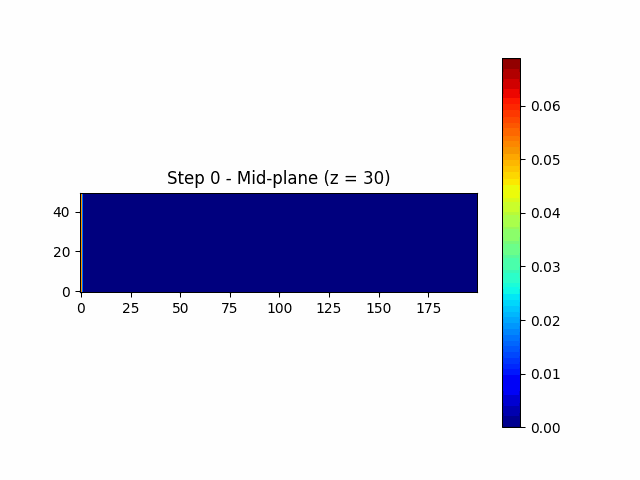

In [ ]:
# @title 3D Post Processing

FILENAME = 'lbm_sim_d3q15'


# Load simulation history
data = np.load(FILENAME+'.npz')
history = data['history']

# Directory to save frames
frames_dir = 'frames_'+FILENAME
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Select the center slice along the z-axis
center_z = 30 #history[0].shape[2] // 2  # Mid-plane in the z-direction

# Create a GIF from the simulation history
frames = []
for i in range(len(history)):
    u_x = history[i][:, :, center_z, 0]  # X-component of the velocity at the mid-plane
    plt.imshow(u_x.T, origin='lower', cmap='jet', interpolation='bilinear')
    plt.colorbar()
    plt.title(f'Step {i * 5} - Mid-plane (z = {center_z})')

    # Save the current frame to a file in the frames directory
    frame_path = os.path.join(frames_dir, f'frame_{i}.png')
    plt.savefig(frame_path)
    plt.close()

    # Read the saved frame
    frames.append(imageio.imread(frame_path))

# Save the frames as a GIF
imageio.mimsave(FILENAME+'.gif', frames, fps=10, loop=0)

# Optional: Clean up frame files if no longer needed
#import shutil
#shutil.rmtree(frames_dir)

# Display the GIF (if running in a notebook)
from IPython.display import Image
Image(filename=FILENAME+'.gif')



---
Images from:  
[1] Modelling viscoacoustic wave propagation with the lattice Boltzmann method, https://www.nature.com/articles/s41598-017-10833-w
